In [1]:
!pip install tikzplotlib==0.9.17


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 976.0 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib
from scipy.stats import pearsonr
from google.colab import files
from scipy.stats import chi2
from scipy.stats import zscore
import os
import shutil

In [3]:
def load_mega_metrics(file_path):
    df = pd.read_csv(file_path)
    return df

def check_data_integrity(df):
    # Checking data for inf and nan
    inf_nan_check = df.isin([float('inf'), float('-inf'), pd.NA]).sum()

    # Checking the data for zero values
    zero_check = (df == 0).sum()

    # Display the number of zero values in each column
    # print(zero_check)

    # Display the number of infinite and NaN values in each column
    # print(inf_nan_check)

    return inf_nan_check, zero_check

  # Results
    # No inf or Nans - Cleaned
    # Number of Zeros
    # Average Clustering Coefficient                                                        40
    # Standard Deviation of Clustering Coefficient                                          40
    # Minimum Node Betweenness Centrality                                                   79
    # Minimum Edge Betweenness Centrality                                                    1
    # Has Bridges                                                                           53
    # Is Planar                                                                              7

def get_columns(df):
    return df.columns.tolist()

def metrics():
    # Selected metrics for outlier detection
    selected_metrics = [
         # Number of elements
        'Number of Nodes',
        'Number of Edges',
         # Node Degree
        'Average Node Degree',
        'Normalized Average Node Degree',
         # Clustering
        'Average Clustering Coefficient',
         # Diameter
        'Diameter (hops)',
        'Absolute Diameter (Link Lengths(km))',
         # Raio
        'Edge Density (Physical Connectivity)',
         # Shortest Path Length
        'Average Shortest Path Length (Hops)',
        'Absolute Average Link Length (km)',
        'Absolute Standard Deviation of Shortest Path Length (Link Lengths(km))',
         # Efficiency
        'Global Efficiency',
         # Betweenness Centrality
        'Maximum Node Betweenness Centrality',
        'Average Node Betweenness Centrality',
        'Maximum Edge Betweenness Centrality',
        'Average Edge Betweenness Centrality',
        # Spectral Metrics
        'Normalized Spectral Radius (Un-weighted Adjacency Matrix)',
        'Normalised Algebraic Connectivity (Normalized Laplacian)',
        # Normalised Spectral Metrics
        'Normalized Average Link Length ',
        'Normalized Diameter (Link Lengths)',
        'Normalized Average Shortest Path Length (Link Lengths)'
    ]
    return selected_metrics


In [4]:
import scipy.stats as stats
import pandas as pd
import numpy as np



def check_assumptions(df, features):
    """
    Check the assumptions for the Z-score and Mahalanobis distance methods.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    features (list): The list of features to be analyzed.

    Returns:
    dict: A dictionary containing the results of the assumption checks.
    """
    assumptions = {}

    # Check normality assumption for Z-score
    for feature in features:
        _, p_value = stats.normaltest(df[feature])
        assumptions[f"Normality ({feature})"] = p_value > 0.05

    # Monotonicity check
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            feature_i, feature_j = features[i], features[j]

            # Calculate Spearman correlation
            spearman_corr, _ = stats.spearmanr(df[feature_i], df[feature_j])

            # Check if the relationship is monotonic
            is_monotonic = abs(spearman_corr) > 0.5  # You can adjust this threshold

            assumptions[f"Monotonicity ({feature_i}, {feature_j})"] = is_monotonic

    # Absence of Outliers (still relevant for Spearman)
    for feature in features:
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        assumptions[f"No Outliers ({feature})"] = len(outliers) == 0


    # Check multivariate normality assumption for Mahalanobis distance
    # Using Mardia's test (skewness part)
    data = df[features].values
    n, p = data.shape
    centered_data = data - np.mean(data, axis=0)
    cov = np.cov(centered_data.T)
    mahalanobis = np.sum(centered_data.dot(np.linalg.inv(cov)) * centered_data, axis=1)
    skewness = np.mean(mahalanobis**3) / (6 * p)
    statistic = n * skewness / 6
    df_skewness = p * (p + 1) * (p + 2) / 6
    p_value = 1 - stats.chi2.cdf(statistic, df_skewness)
    assumptions["Multivariate Normality"] = p_value > 0.05

    # Check homogeneity of variance assumption
    levene_stats, p_value = stats.levene(*[df[feature] for feature in features])
    assumptions["Homogeneity of Variance"] = p_value > 0.05

    # Check linearity assumption for Mahalanobis distance
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            feature_i, feature_j = features[i], features[j]
            slope, intercept, r_value, _, _ = stats.linregress(df[feature_i], df[feature_j])
            assumptions[f"Linearity ({feature_i}, {feature_j})"] = abs(r_value) > 0.5

    return assumptions

def pretty_print_assumptions(assumptions):
    print("Assumptions Check Results:")
    print("--------------------------")
    for assumption, result in assumptions.items():
        status = "Met" if result else "Not Met"
        print(f"{assumption:<50} : {status}")
    print("--------------------------")


def identify_outliers_zscore(df, features, threshold=3):
    z_scores = df[features].apply(zscore)
    outliers = df[(z_scores.abs() > threshold).any(axis=1)].copy()
    outliers['Z-score Magnitude'] = z_scores.loc[outliers.index].abs().max(axis=1)
    contributing_features = z_scores.abs() > threshold
    outliers['Total Contributing Features'] = contributing_features.sum(axis=1)
    outliers['Contributing Features'] = contributing_features.apply(
        lambda x: ', '.join(x.index[x].tolist()), axis=1
    )
    return outliers[['Topology Name', 'Total Contributing Features', 'Contributing Features', 'Z-score Magnitude']]


def compute_mahalanobis(df, features):
    # Compute the mean vector and covariance matrix
    mean_vector = df[features].mean(axis=0)
    cov_matrix = np.cov(df[features].values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Compute Mahalanobis distance for each topology
    mahalanobis_distances = []
    for index, row in df[features].iterrows():
        diff_vector = row - mean_vector
        mahalanobis_distance = np.sqrt(np.dot(np.dot(diff_vector, inv_cov_matrix), diff_vector.T))
        mahalanobis_distances.append(mahalanobis_distance)

    return np.array(mahalanobis_distances)



def identify_outliers_mahalanobis(df, selected_metrics_for_outliers):
    # Compute Mahalanobis distances
    mahalanobis_distances = compute_mahalanobis(df, selected_metrics_for_outliers)

    # Add Mahalanobis distances to the dataframe
    df['Mahalanobis Distance'] = mahalanobis_distances

    # Compute the squared Mahalanobis distance
    df['Squared Mahalanobis Distance'] = df['Mahalanobis Distance'] ** 2

    # Compute p-values for Mahalanobis distances
    df['p-value'] = 1 - chi2.cdf(df['Squared Mahalanobis Distance'], df[selected_metrics_for_outliers].shape[1])

    # Identify outliers based on p-value threshold (e.g., p-value < 0.01)
    outliers_mahalanobis = df[df['p-value'] < 0.05].copy()

    outliers_mahalanobis['Total Contributing Features'] = len(selected_metrics_for_outliers)
    outliers_mahalanobis['Contributing Features'] = ', '.join(selected_metrics_for_outliers)

    return outliers_mahalanobis[['Topology Name', 'Total Contributing Features', 'Contributing Features', 'Mahalanobis Distance', 'p-value']]



In [5]:
# Load the analysis file
df = load_mega_metrics('/content/mega_graph_metrics.csv')
# print("Dataset")
# print(df.head(5))
# print("-----------------------------------------")

# Display columns
# columns = get_columns(df)
# print("Columns")
# print(columns)
# print("-----------------------------------------")

# Check Data
inf_nan_check, zero_check = check_data_integrity(df)
# print("Data Checks")
# print(inf_nan_check)
# print("-----------------------------------------")
# print(zero_check)
# print("-----------------------------------------")

# Metrics for outlier detection
selected_metrics = metrics()
print("Selected Metrics")
print(selected_metrics)
print("-----------------------------------------")

assumptions = check_assumptions(df, selected_metrics)
print("Assumptions")
# print(assumptions)
print("-----------------------------------------")
pretty_print_assumptions(assumptions)

Selected Metrics
['Number of Nodes', 'Number of Edges', 'Average Node Degree', 'Normalized Average Node Degree', 'Average Clustering Coefficient', 'Diameter (hops)', 'Absolute Diameter (Link Lengths(km))', 'Edge Density (Physical Connectivity)', 'Average Shortest Path Length (Hops)', 'Absolute Average Link Length (km)', 'Absolute Standard Deviation of Shortest Path Length (Link Lengths(km))', 'Global Efficiency', 'Maximum Node Betweenness Centrality', 'Average Node Betweenness Centrality', 'Maximum Edge Betweenness Centrality', 'Average Edge Betweenness Centrality', 'Normalized Spectral Radius (Un-weighted Adjacency Matrix)', 'Normalised Algebraic Connectivity (Normalized Laplacian)', 'Normalized Average Link Length ', 'Normalized Diameter (Link Lengths)', 'Normalized Average Shortest Path Length (Link Lengths)']
-----------------------------------------
Assumptions
-----------------------------------------
Assumptions Check Results:
--------------------------
Normality (Number of Node

In [6]:
assumptions["Multivariate Normality"]

False

In [7]:
# assumptions.to_csv("assumptions.csv")
# print("-----------------------------------------")
# print("Saved as assumptions.csv ")
# print("-----------------------------------------")

In [8]:
assumptions["Homogeneity of Variance"]

False

In [27]:
# Identify outliers using Z-scores
outliers_z_score = identify_outliers_zscore(df, selected_metrics)
print("Outliers using Z-scores")
print(outliers_z_score)
print("-----------------------------------------")
print("Total Number of Outliers using Z-scores")
print(len(outliers_z_score))
print("-----------------------------------------")
print(outliers_z_score)
outliers_z_score.to_csv("outliers_z_score.csv")
print("-----------------------------------------")
print("Saved as outliers_z_score.csv ")
print("-----------------------------------------")

Outliers using Z-scores
            Topology Name  Total Contributing Features  \
10                 GETNET                            1   
12                 GBLNET                            1   
14                TATANID                            4   
18                   SAGO                            2   
19                 CESNET                            1   
21                NEXTGEN                            1   
22                LAYER42                            3   
23                NETRAIL                            3   
27       GTSCZECHREPUBLIC                            1   
29                  EPOCH                            2   
35                 USA100                            2   
36   HOSTWAYINTERNATIONAL                            3   
38            RENATER1999                            1   
56               CONUS100                            4   
64                 MARWAN                            1   
72                    EON                       

In [28]:
# Identify outliers using Mahalanobis distance
outliers_mahalanobis = identify_outliers_mahalanobis(df,selected_metrics )
print("Outliers using Mahalanobis distance")
print("-----------------------------------------")
print("Total Number of Outliers using Mahalanobis distance: ")
print(len(outliers_mahalanobis))
print("-----------------------------------------")
print(outliers_mahalanobis)
outliers_mahalanobis.to_csv("outliers_mahalanobis.csv")
print("-----------------------------------------")
print("Saved as outliers_mahalanobis.csv ")
print("-----------------------------------------")

Outliers using Mahalanobis distance
-----------------------------------------
Total Number of Outliers using Mahalanobis distance: 
13
-----------------------------------------
            Topology Name  Total Contributing Features  \
12                 GBLNET                           21   
14                TATANID                           21   
19                 CESNET                           21   
20              GERMANY50                           21   
22                LAYER42                           21   
23                NETRAIL                           21   
29                  EPOCH                           21   
35                 USA100                           21   
36   HOSTWAYINTERNATIONAL                           21   
56               CONUS100                           21   
59         HIBERNIAGLOBAL                           21   
84                  ISTAR                           21   
101        PACKETEXCHANGE                           21   

          

In [11]:
# Check if all indices in outliers_mahalanobis are in outliers_z_score
is_subset = outliers_mahalanobis.index.isin(outliers_z_score.index).all()

# Display the result
print("Is outliers_mahalanobis a subset of outliers_z_score?", is_subset)

Is outliers_mahalanobis a subset of outliers_z_score? False


In [12]:
# Find the intersection of the two outlier sets
common_outliers = outliers_z_score.index.intersection(outliers_mahalanobis.index)

# Get the common outliers data
common_outliers_df = df.loc[common_outliers]

# Display the common outliers
common_outliers_df

,Topology Name,Number of Nodes,Number of Edges,Average Node Degree,Normalized Average Node Degree,Diameter (hops),Edge Density (Physical Connectivity),Average Shortest Path Length (Hops),Standard Deviation of Shortest Path Length (Hops),Average Clustering Coefficient,...,Coefficient of Variation of Normalized Average Link Length,Normalized Diameter (Link Lengths),Normalized Average Shortest Path Length (Link Lengths),Coefficient of Variation of Normalized Average Shortest Path Length (Link Lengths),Has Bridges,Is Planar,Is Connected,Mahalanobis Distance,Squared Mahalanobis Distance,p-value
12,GBLNET,8,7,1.750000,0.250000,4,0.250000,2.214286,0.976771,0.000000,...,0.413000,0.720344,0.356958,0.633944,1,1,1,5.771546,33.310740,4.288305e-02
14,TATANID,142,180,2.535211,0.017980,28,0.017980,9.818400,5.140537,0.065023,...,0.653275,0.141836,0.058005,0.533214,1,1,1,7.428024,55.175535,6.664553e-05
19,CESNET,12,19,3.166667,0.287879,4,0.287879,2.030303,0.815934,0.686111,...,0.338928,0.173240,0.100700,0.471769,0,1,1,6.198818,38.425340,1.148589e-02
22,LAYER42,6,7,2.333333,0.466667,3,0.466667,1.666667,0.699206,0.416667,...,0.731021,0.467578,0.262601,0.635536,1,1,1,7.978839,63.661864,3.510236e-06
23,NETRAIL,7,10,2.857143,0.476190,2,0.476190,1.523810,0.499433,0.566667,...,0.853132,0.324082,0.144637,0.729899,0,1,1,8.725200,76.129119,3.543669e-08
29,EPOCH,6,7,2.333333,0.466667,3,0.466667,1.666667,0.699206,0.000000,...,0.611873,0.324447,0.197182,0.553807,0,1,1,7.612303,57.947160,2.598499e-05
35,USA100,100,171,3.420000,0.034545,16,0.034545,6.517778,3.215554,0.118667,...,0.619281,0.108823,0.041369,0.605061,0,1,1,10.624505,112.880111,1.421085e-14
36,HOSTWAYINTERNATIONAL,16,21,2.625000,0.175000,8,0.175000,3.283333,1.728117,0.260417,...,1.377509,0.304565,0.118795,0.719443,1,1,1,7.236012,52.359870,1.697513e-04
56,CONUS100,100,136,2.720000,0.027475,15,0.027475,6.674141,2.902921,0.000000,...,1.736764,0.144879,0.042904,0.813559,0,0,1,7.564635,57.223702,3.329217e-05
101,PACKETEXCHANGE,21,27,2.571429,0.128571,9,0.128571,3.642857,1.917606,0.134921,...,1.218107,0.400281,0.118189,0.732472,1,1,1,8.297739,68.852465,5.361004e-07


In [13]:
# Compute the correlation matrix
p_correlation_matrix = df[selected_metrics].corr()

# Calculate the absolute values of the correlation coefficients
abs_correlation_matrix = p_correlation_matrix.abs()

# Compute the average absolute correlation, excluding the diagonal
num_features = abs_correlation_matrix.shape[0]
avg_abs_correlation = (abs_correlation_matrix.values.sum() - num_features) / (num_features * (num_features - 1))

# Display the average absolute correlation
print("Average Absolute Correlation:", avg_abs_correlation)
p_correlation_matrix.to_csv("p_correlation_matrix.csv")

Average Absolute Correlation: 0.3645913237812482


In [14]:
p_correlation_matrix

,Number of Nodes,Number of Edges,Average Node Degree,Normalized Average Node Degree,Average Clustering Coefficient,Diameter (hops),Absolute Diameter (Link Lengths(km)),Edge Density (Physical Connectivity),Average Shortest Path Length (Hops),Absolute Average Link Length (km),...,Global Efficiency,Maximum Node Betweenness Centrality,Average Node Betweenness Centrality,Maximum Edge Betweenness Centrality,Average Edge Betweenness Centrality,Normalized Spectral Radius (Un-weighted Adjacency Matrix),Normalised Algebraic Connectivity (Normalized Laplacian),Normalized Average Link Length,Normalized Diameter (Link Lengths),Normalized Average Shortest Path Length (Link Lengths)
Number of Nodes,1.000000,0.977513,0.247130,-0.628653,-0.114933,0.814228,0.213272,-0.628653,0.841885,-0.180492,...,-0.728058,-0.231892,-0.517065,-0.243080,-0.552353,-0.175121,-0.452849,-0.595970,-0.446895,-0.527737
Number of Edges,0.977513,1.000000,0.403948,-0.580167,-0.012920,0.744478,0.215601,-0.580167,0.765584,-0.155283,...,-0.664352,-0.283381,-0.576046,-0.325050,-0.613857,-0.132539,-0.416232,-0.601506,-0.523864,-0.597044
Average Node Degree,0.247130,0.403948,1.000000,-0.084709,0.618773,-0.017044,0.106552,-0.084709,-0.046049,0.066887,...,-0.007263,-0.398227,-0.680233,-0.656437,-0.754398,-0.003582,-0.055168,-0.490200,-0.735424,-0.771337
Normalized Average Node Degree,-0.628653,-0.580167,-0.084709,1.000000,0.276401,-0.695959,-0.134046,1.000000,-0.746810,0.323336,...,0.953855,-0.059435,0.381486,-0.044141,0.536179,0.382785,0.827681,0.869633,0.256851,0.488566
Average Clustering Coefficient,-0.114933,-0.012920,0.618773,0.276401,1.000000,-0.280003,0.021541,0.276401,-0.319963,0.175559,...,0.331958,-0.051964,-0.340314,-0.303252,-0.347251,-0.118608,0.280311,-0.090167,-0.360013,-0.330229
Diameter (hops),0.814228,0.744478,-0.017044,-0.695959,-0.280003,1.000000,0.167101,-0.695959,0.979955,-0.248930,...,-0.851483,-0.093119,-0.105267,0.145968,-0.252235,-0.101891,-0.628464,-0.565983,-0.050518,-0.258606
Absolute Diameter (Link Lengths(km)),0.213272,0.215601,0.106552,-0.134046,0.021541,0.167101,1.000000,-0.134046,0.176060,0.785772,...,-0.159450,-0.107158,-0.112696,0.002360,-0.159140,0.109788,-0.134511,-0.168806,-0.103176,-0.203676
Edge Density (Physical Connectivity),-0.628653,-0.580167,-0.084709,1.000000,0.276401,-0.695959,-0.134046,1.000000,-0.746810,0.323336,...,0.953855,-0.059435,0.381486,-0.044141,0.536179,0.382785,0.827681,0.869633,0.256851,0.488566
Average Shortest Path Length (Hops),0.841885,0.765584,-0.046049,-0.746810,-0.319963,0.979955,0.176060,-0.746810,1.000000,-0.265074,...,-0.897721,-0.109173,-0.139505,0.105860,-0.276714,-0.118650,-0.653852,-0.597983,-0.076866,-0.271852
Absolute Average Link Length (km),-0.180492,-0.155283,0.066887,0.323336,0.175559,-0.248930,0.785772,0.323336,-0.265074,1.000000,...,0.321023,-0.048432,0.029024,-0.042349,0.055849,0.184290,0.303500,0.201959,-0.038656,-0.008131


In [15]:
# Using Spearman correlation
s_correlation_matrix = df[selected_metrics].corr(method='spearman')

# Calculate the absolute values of the correlation coefficients
abs_correlation_matrix = s_correlation_matrix.abs()

# Compute the average absolute correlation, excluding the diagonal
num_features = abs_correlation_matrix.shape[0]
avg_abs_correlation = (abs_correlation_matrix.values.sum() - num_features) / (num_features * (num_features - 1))

# Display the average absolute correlation
print("Average Absolute Correlation:", avg_abs_correlation)
s_correlation_matrix.to_csv("s_correlation_matrix.csv")

Average Absolute Correlation: 0.40071890163118945


In [16]:
df[selected_metrics].columns

Index(['Number of Nodes', 'Number of Edges', 'Average Node Degree',
       'Normalized Average Node Degree', 'Average Clustering Coefficient',
       'Diameter (hops)', 'Absolute Diameter (Link Lengths(km))',
       'Edge Density (Physical Connectivity)',
       'Average Shortest Path Length (Hops)',
       'Absolute Average Link Length (km)',
       'Absolute Standard Deviation of Shortest Path Length (Link Lengths(km))',
       'Global Efficiency', 'Maximum Node Betweenness Centrality',
       'Average Node Betweenness Centrality',
       'Maximum Edge Betweenness Centrality',
       'Average Edge Betweenness Centrality',
       'Normalized Spectral Radius (Un-weighted Adjacency Matrix)',
       'Normalised Algebraic Connectivity (Normalized Laplacian)',
       'Normalized Average Link Length ', 'Normalized Diameter (Link Lengths)',
       'Normalized Average Shortest Path Length (Link Lengths)'],
      dtype='object')

In [17]:
df.columns

Index(['Topology Name', 'Number of Nodes', 'Number of Edges',
       'Average Node Degree', 'Normalized Average Node Degree',
       'Diameter (hops)', 'Edge Density (Physical Connectivity)',
       'Average Shortest Path Length (Hops)',
       'Standard Deviation of Shortest Path Length (Hops)',
       'Average Clustering Coefficient',
       'Standard Deviation of Clustering Coefficient',
       'Minimum Node Betweenness Centrality',
       'Maximum Node Betweenness Centrality',
       'Average Node Betweenness Centrality',
       'Minimum Edge Betweenness Centrality',
       'Maximum Edge Betweenness Centrality',
       'Average Edge Betweenness Centrality', 'Global Efficiency',
       'Graph Center (Nodes)', 'Number of Graph Center Nodes',
       'Graph Periphery (Nodes)', 'Number of Graph Periphery Nodes',
       'Absolute Spectral Radius (Weighted Adjacency Matrix)',
       'Normalized Spectral Radius (Un-weighted Adjacency Matrix)',
       'Normalised Spectral Radius (Normalized

In [18]:
def compute_and_plot_correlation_matrix(cleaned_data, plot_file_path, csv_file_path, tikz_file_path, method='pearson'):
    short_labels = [
    "Num_Nodes",
    "Num_Edges",
    "Avg_Node_Degree",
    "Norm_Avg_Node_Degree",
    "Avg_Clust_Coeff",
    "Diameter_Hops",
    "Abs_Diameter_Km",
    "Edge_Density_Phys_Conn",
    "Avg_Shortest_Path_Hops",
    "Abs_Avg_Link_Length_Km",
    "Abs_StdDev_Shortest_Path_Km",
    "Global_Efficiency",
    "Max_Node_Betw_Centrality",
    "Avg_Node_Betw_Centrality",
    "Max_Edge_Betw_Centrality",
    "Avg_Edge_Betw_Centrality",
    "Norm_Spectral_Radius",
    "Norm_Alg_Connectivity",
    "Norm_Avg_Link_Length",
    "Norm_Diameter_Lengths",
    "Norm_Avg_Shortest_Path_Lengths"
    ]

    numeric_data = cleaned_data.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr().round(2)

    plt.figure(figsize=(18, 12))
    plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix.columns)), short_labels, rotation=90, fontsize=12)
    plt.yticks(range(len(correlation_matrix.columns)), short_labels, fontsize=12)

    for (i, j), val in np.ndenumerate(correlation_matrix.values):
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=10, color='black')

    plt.savefig(plot_file_path)
    # tikzplotlib.save(tikz_file_path)
    plt.show()

    correlation_matrix.to_csv(csv_file_path)
    return correlation_matrix

def calculate_p_value(series1, series2):
    correlation, p_value = pearsonr(series1, series2)
    return p_value

def get_strongest_correlations(correlation_matrix, numeric_data):
    strongest_correlations = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
    strongest_correlations = strongest_correlations[strongest_correlations != 1]

    strongest_negative_correlations = strongest_correlations[strongest_correlations < 0].sort_values()

    strongest_correlations_with_p = []
    strongest_negative_correlations_with_p = []

    for index, value in strongest_correlations.items():
        var1, var2 = index
        p_value = calculate_p_value(numeric_data[var1], numeric_data[var2])
        strongest_correlations_with_p.append((var1, var2, value, p_value))

    for index, value in strongest_negative_correlations.items():
        var1, var2 = index
        p_value = calculate_p_value(numeric_data[var1], numeric_data[var2])
        strongest_negative_correlations_with_p.append((var1, var2, value, p_value))

    strongest_correlations_with_p_df = pd.DataFrame(strongest_correlations_with_p, columns=['Variable 1', 'Variable 2', 'Correlation Coefficient', 'P-Value'])
    strongest_negative_correlations_with_p_df = pd.DataFrame(strongest_negative_correlations_with_p, columns=['Variable 1', 'Variable 2', 'Correlation Coefficient', 'P-Value'])

    return strongest_correlations_with_p_df, strongest_negative_correlations_with_p_df

def get_correlations_and_p_values(data):
    correlations = []
    columns = data.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1, col2 = columns[i], columns[j]
            corr, p_value = pearsonr(data[col1], data[col2])
            correlations.append((col1, col2, corr, p_value))
    return pd.DataFrame(correlations, columns=['Variable 1', 'Variable 2', 'Correlation Coefficient', 'P-Value'])

def filter_strongest_correlations(corr_df, corr_threshold=0.7, p_value_threshold=0.05):
    return corr_df[(corr_df['P-Value'] < p_value_threshold) & (corr_df['Correlation Coefficient'].abs() > corr_threshold)]

def compute_summary_statistics(cleaned_data):
    summary = cleaned_data.describe().loc[['mean', 'std', 'min', 'max']]
    summary_transposed = summary.T.reset_index()
    summary_transposed.columns = ['property', 'mean', 'stdev', 'min', 'max']
    return summary_transposed

def save_dataframe_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

In [19]:
# Define the file paths
input_file_path = 'mega_graph_metrics.csv'
summary_output_file_path = 'summary_of_mega_metrics_transposed.csv'

summary_metrics = ['Number of Nodes',
                   'Number of Edges',
                   'Average Node Degree',
                   'Normalized Average Node Degree',
                   'Average Clustering Coefficient',
                   'Diameter (hops)',
                   'Absolute Diameter (Link Lengths(km))',
                   'Edge Density (Physical Connectivity)',
                   'Average Shortest Path Length (Hops)',
                   'Absolute Average Link Length (km)',
                  'Absolute Standard Deviation of Shortest Path Length (Link Lengths(km))',
                  'Global Efficiency', 'Maximum Node Betweenness Centrality',
                  'Average Node Betweenness Centrality',
                  'Maximum Edge Betweenness Centrality',
                  'Average Edge Betweenness Centrality',
                  'Normalized Spectral Radius (Un-weighted Adjacency Matrix)',
                  'Normalised Algebraic Connectivity (Normalized Laplacian)',
                  'Normalized Average Link Length ',
                  'Normalized Diameter (Link Lengths)',
                  'Normalized Average Shortest Path Length (Link Lengths)']

# Load and clean the data
cleaned_summary_data = df[summary_metrics]

# Compute the summary statistics
corrected_summary_transposed = compute_summary_statistics(cleaned_summary_data)

# Save the summary statistics to a CSV file
save_dataframe_to_csv(corrected_summary_transposed, summary_output_file_path)

corrected_summary_transposed

,property,mean,stdev,min,max
0,Number of Nodes,26.028571,20.285205,6.000000,142.000000
1,Number of Edges,34.209524,29.252119,6.000000,180.000000
2,Average Node Degree,2.546325,0.431357,1.750000,3.894737
3,Normalized Average Node Degree,0.151694,0.098991,0.017980,0.476190
4,Average Clustering Coefficient,0.113068,0.136595,0.000000,0.686111
5,Diameter (hops),8.047619,4.105299,2.000000,28.000000
6,Absolute Diameter (Link Lengths(km)),5343.295654,5459.772472,349.500000,36855.121523
7,Edge Density (Physical Connectivity),0.151694,0.098991,0.017980,0.476190
8,Average Shortest Path Length (Hops),3.590185,1.380766,1.523810,9.818400
9,Absolute Average Link Length (km),687.918551,688.937704,32.527273,4159.836963


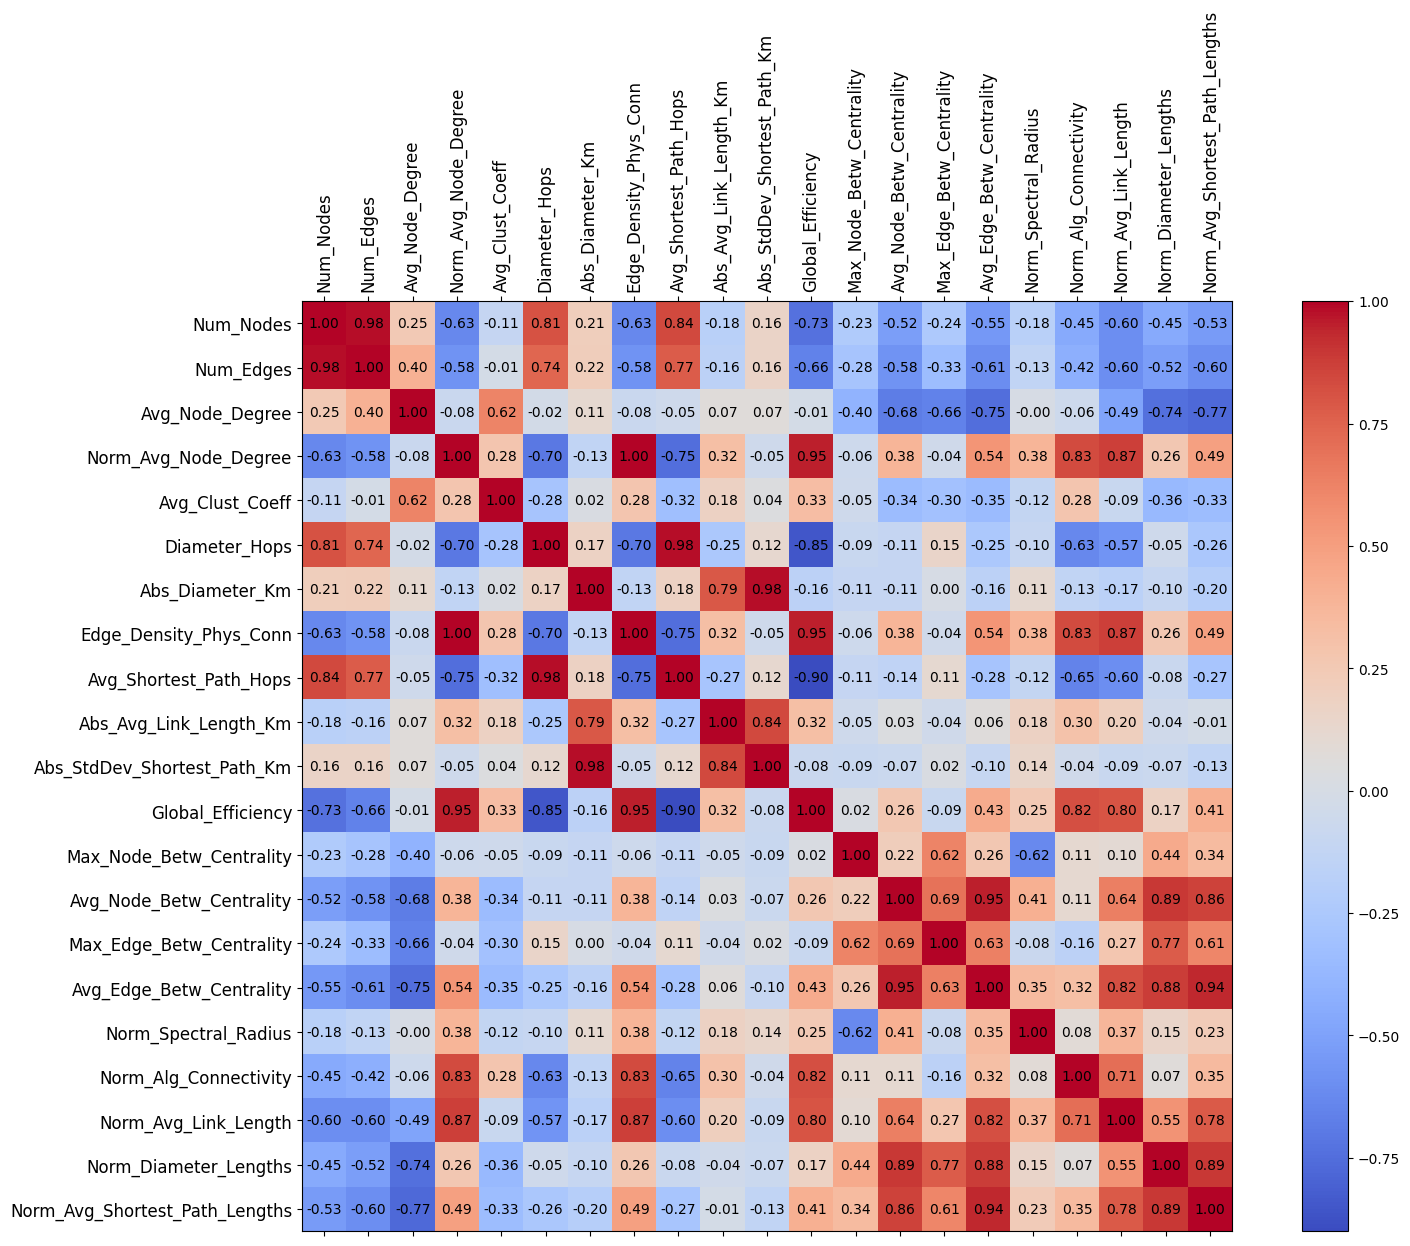

In [20]:
# Pearson
# Pearson
correlation_plot_file_path = 'p_correlation_matrix_plot.png'
correlation_csv_file_path = 'p_correlation_matrix.csv'
correlation_tikz_file_path = 'p_correlation_matrix_plot.tex'
strongest_correlations_csv_path = 'p_strongest_correlations.csv'
strongest_correlations_with_p_csv_path = 'p_strongest_correlations_with_p.csv'
strongest_negative_correlations_with_p_csv_path = 'p_strongest_negative_correlations_with_p.csv'
correlation_results_csv_path = 'p_correlation_results.csv'

# Load and clean the data
cleaned_data = df[selected_metrics]

# Compute and plot the correlation matrix, then save the plot and the matrix as files
correlation_matrix = compute_and_plot_correlation_matrix(cleaned_data, correlation_plot_file_path, correlation_csv_file_path, correlation_tikz_file_path, method='pearson')

# Get strongest correlations
strongest_correlations_with_p_df, strongest_negative_correlations_with_p_df = get_strongest_correlations(correlation_matrix, cleaned_data.select_dtypes(include=[np.number]))

# Calculate correlations and p-values for the numeric columns
correlation_results = get_correlations_and_p_values(cleaned_data.select_dtypes(include=[np.number]))

# Filter to get the strongest correlations
strongest_correlations_df = filter_strongest_correlations(correlation_results)

# Save the dataframes as CSV files
save_dataframe_to_csv(strongest_correlations_df, strongest_correlations_csv_path)
save_dataframe_to_csv(strongest_correlations_with_p_df, strongest_correlations_with_p_csv_path)
save_dataframe_to_csv(strongest_negative_correlations_with_p_df, strongest_negative_correlations_with_p_csv_path)
save_dataframe_to_csv(correlation_results, correlation_results_csv_path)


In [21]:
strongest_correlations_df

,Variable 1,Variable 2,Correlation Coefficient,P-Value
0,Number of Nodes,Number of Edges,0.977513,1.898273e-71
4,Number of Nodes,Diameter (hops),0.814228,4.537029e-26
7,Number of Nodes,Average Shortest Path Length (Hops),0.841885,2.375015e-29
10,Number of Nodes,Global Efficiency,-0.728058,1.375652e-18
23,Number of Edges,Diameter (hops),0.744478,8.865043e-20
26,Number of Edges,Average Shortest Path Length (Hops),0.765584,1.890903e-21
51,Average Node Degree,Average Edge Betweenness Centrality,-0.754398,1.525230e-20
55,Average Node Degree,Normalized Diameter (Link Lengths),-0.735424,4.123126e-19
56,Average Node Degree,Normalized Average Shortest Path Length (Link ...,-0.771337,6.173657e-22
60,Normalized Average Node Degree,Edge Density (Physical Connectivity),1.000000,0.000000e+00


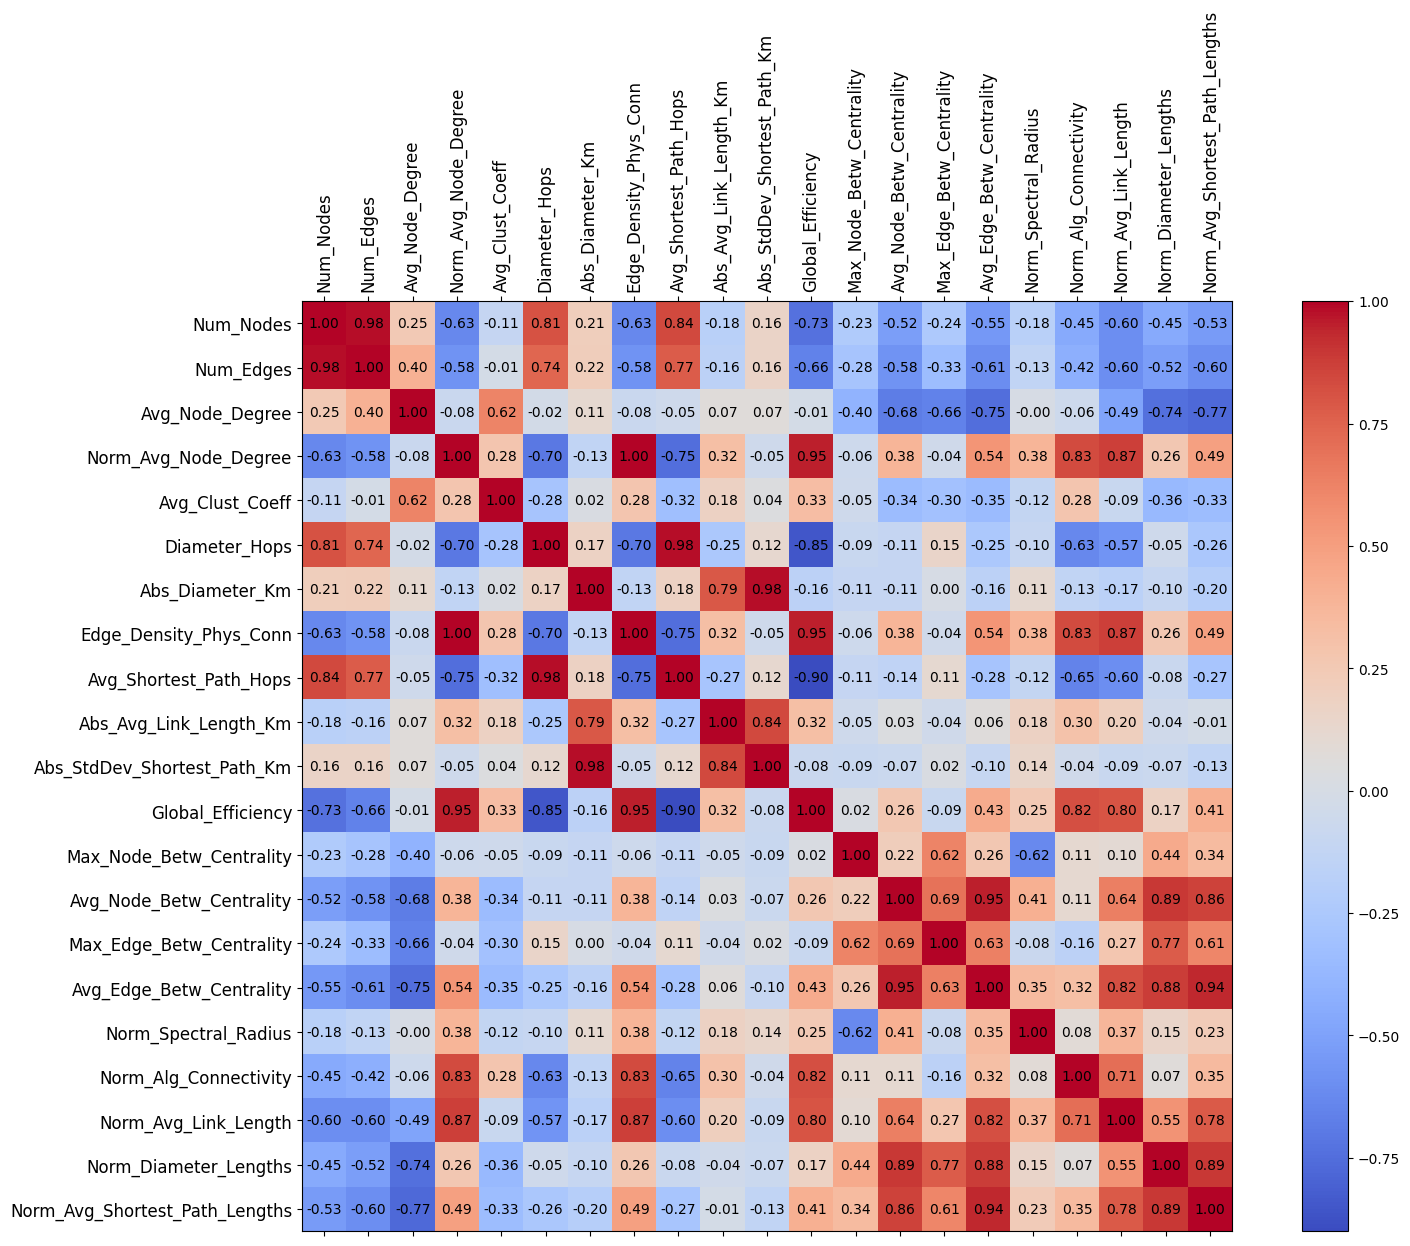

In [22]:
# Spearman
correlation_plot_file_path = 's_correlation_matrix_plot.png'
correlation_csv_file_path = 's_correlation_matrix.csv'
correlation_tikz_file_path = 's_correlation_matrix_plot.tex'
strongest_correlations_csv_path = 's_strongest_correlations.csv'
strongest_correlations_with_p_csv_path = 's_strongest_correlations_with_p.csv'
strongest_negative_correlations_with_p_csv_path = 's_strongest_negative_correlations_with_p.csv'
correlation_results_csv_path = 's_correlation_results.csv'

# Compute and plot the correlation matrix, then save the plot and the matrix as files
correlation_matrix = compute_and_plot_correlation_matrix(cleaned_data, correlation_plot_file_path, correlation_csv_file_path, correlation_tikz_file_path, method='spearman')

# Get strongest correlations
strongest_correlations_with_p_df, strongest_negative_correlations_with_p_df = get_strongest_correlations(correlation_matrix, cleaned_data.select_dtypes(include=[np.number]))

# Calculate correlations and p-values for the numeric columns
correlation_results = get_correlations_and_p_values(cleaned_data.select_dtypes(include=[np.number]))

# Filter to get the strongest correlations
strongest_correlations_df = filter_strongest_correlations(correlation_results)

# Save the dataframes as CSV files
save_dataframe_to_csv(strongest_correlations_df, strongest_correlations_csv_path)
save_dataframe_to_csv(strongest_correlations_with_p_df, strongest_correlations_with_p_csv_path)
save_dataframe_to_csv(strongest_negative_correlations_with_p_df, strongest_negative_correlations_with_p_csv_path)
save_dataframe_to_csv(correlation_results, correlation_results_csv_path)


In [23]:
strongest_correlations_df

,Variable 1,Variable 2,Correlation Coefficient,P-Value
0,Number of Nodes,Number of Edges,0.977513,1.898273e-71
4,Number of Nodes,Diameter (hops),0.814228,4.537029e-26
7,Number of Nodes,Average Shortest Path Length (Hops),0.841885,2.375015e-29
10,Number of Nodes,Global Efficiency,-0.728058,1.375652e-18
23,Number of Edges,Diameter (hops),0.744478,8.865043e-20
26,Number of Edges,Average Shortest Path Length (Hops),0.765584,1.890903e-21
51,Average Node Degree,Average Edge Betweenness Centrality,-0.754398,1.525230e-20
55,Average Node Degree,Normalized Diameter (Link Lengths),-0.735424,4.123126e-19
56,Average Node Degree,Normalized Average Shortest Path Length (Link ...,-0.771337,6.173657e-22
60,Normalized Average Node Degree,Edge Density (Physical Connectivity),1.000000,0.000000e+00


In [24]:
def plot_pairwise_scatter_plots(data):
    numerical_cols = data.select_dtypes(include='number').columns
    filtered_data = data[numerical_cols]
    # print(filtered_data.head())

    output_dir = '/content/pairwise_plots'
    os.makedirs(output_dir, exist_ok=True)

    for i, col1 in enumerate(numerical_cols):
        for j, col2 in enumerate(numerical_cols):
            if i >= j:
                continue
            plt.figure(figsize=(6, 6))
            plt.scatter(filtered_data[col1], filtered_data[col2], alpha=0.7, color='red', edgecolor='k')
            plt.xlabel(col1, fontsize=12)
            plt.ylabel(col2, fontsize=12)
            plt.title(f'{col1} vs {col2}', fontsize=14)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plot_path = f'{output_dir}/{col1}_vs_{col2}'
            plt.savefig(f'{plot_path}.png', dpi=50)
            try:
                tikzplotlib.save(f'{plot_path}.tex')
            except Exception as e:
                print(f"Failed to save {plot_path}.tex: {e}")
            plt.close()
    print(f'Pairwise scatter plots saved to {output_dir}')

def plot_pairwise_scatter_plots_log(data):
    numerical_cols = data.select_dtypes(include='number').columns
    filtered_data = data[numerical_cols]

    output_dir = '/content/pairwise_plots_log'
    os.makedirs(output_dir, exist_ok=True)

    for i, col1 in enumerate(numerical_cols):
        for j, col2 in enumerate(numerical_cols):
            if i >= j:
                continue
            plt.figure(figsize=(6, 6))
            plt.scatter(filtered_data[col1], filtered_data[col2], alpha=0.7, color='red', edgecolor='k')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel(col1, fontsize=12)
            plt.ylabel(col2, fontsize=12)
            plt.title(f'{col1} vs {col2} (Log-Log)', fontsize=14)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plot_path = f'{output_dir}/{col1}_vs_{col2}_log'
            plt.savefig(f'{plot_path}.png', dpi=50)
            try:
                tikzplotlib.save(f'{plot_path}.tex')
            except Exception as e:
                print(f"Failed to save {plot_path}.tex: {e}")
            plt.close()
    print(f'Pairwise log-log scatter plots saved to {output_dir}')

def zip_directory(directory_path, output_zip_path):
    """
    Zips the specified directory and saves it to the output path.

    Parameters:
    directory_path (str): Path to the directory to be zipped.
    output_zip_path (str): Path where the zip file will be saved.
    """
    shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', directory_path)

def download_file(file_path):
    """
    Provides a link to download the specified file.

    Parameters:
    file_path (str): Path to the file to be downloaded.
    """
    files.download(file_path)

In [25]:
# Plot pairwise scatter plots and save them
plot_pairwise_scatter_plots(cleaned_data)

# Define the directory and zip file paths
directory_path = '/content/pairwise_plots'
output_zip_path = '/content/pairwise_plots.zip'

# Zip the directory
# zip_directory(directory_path, output_zip_path)

# Download the zip file
# download_file(output_zip_path)

# Generate pairwise scatter plots on a log-log scale
plot_pairwise_scatter_plots_log(cleaned_data)

# Define the directory and zip file paths
directory_path = '/content/pairwise_plots_log'
output_zip_path = '/content/pairwise_plots_log.zip'

# Zip the directory
# zip_directory(directory_path, output_zip_path)

# Download the zip file
# download_file(output_zip_path)


Pairwise scatter plots saved to /content/pairwise_plots
Pairwise log-log scatter plots saved to /content/pairwise_plots_log
